<h1>  Model V2  </h1>
<p> Couldn't train due to gpu running out of memory.

<h3>Import libraries<h3>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import cv2
import torch
import os
import glob
from albumentations import (
    Compose, HorizontalFlip, RandomRotate90, RandomBrightnessContrast, Resize
)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
import gc


<h3>Installing the dataset.</h3>

In [2]:
! wget http://images.cocodataset.org/zips/test2014.zip

--2024-06-26 18:28:50--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.76.28, 16.182.103.57, 16.182.100.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.76.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: 'test2014.zip'

test2014.zip        100%[===================>]   6.20G  39.3MB/s    in 2m 46s  

2024-06-26 18:31:36 (38.3 MB/s) - 'test2014.zip' saved [6660437059/6660437059]



In [ ]:
! unzip test2014.zip

<h3> Check the device availibility. </h3>

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<h3>Visualising some images. </h3>


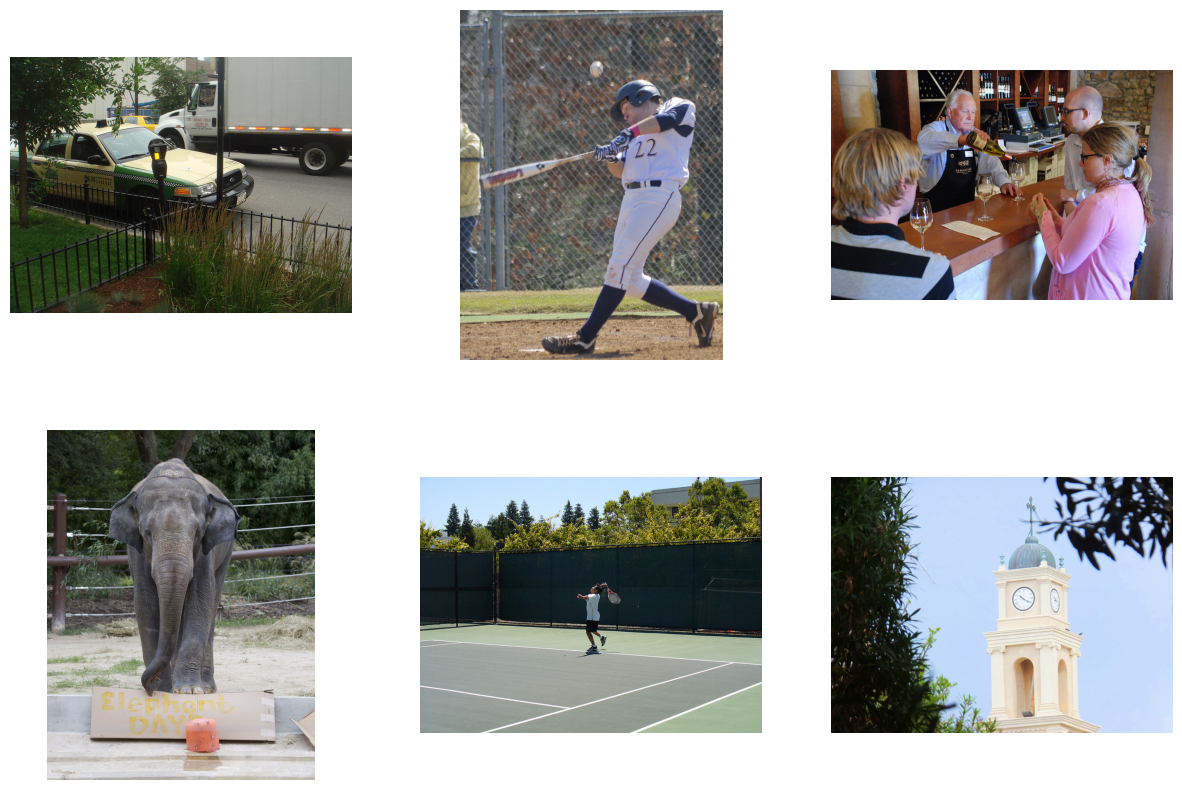

In [5]:
image_paths = ['/kaggle/working/test2014/COCO_test2014_000000000001.jpg','/kaggle/working/test2014/COCO_test2014_000000000016.jpg',
               '/kaggle/working/test2014/COCO_test2014_000000000069.jpg','/kaggle/working/test2014/COCO_test2014_000000000128.jpg',
               '/kaggle/working/test2014/COCO_test2014_000000000219.jpg','/kaggle/working/test2014/COCO_test2014_000000000276.jpg']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, image_path in zip(axes, image_paths):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off')

plt.show()

<br><h3>Data Preprocessing</h3>
<br>
1.   Defineing the custom dataset class. <br>
2.   Resize all images to 128*128. <br>
3.   Convert RGB to LAB and then spliting L and AB channels.



In [28]:
class LABColorizationDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(image)
        L = L / 255.0
        A = (A / 128.0) - 1.0
        B = (B / 128.0) - 1.0

        L = np.stack([L], axis=-1).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=L)
            L = augmented['image']

        target_size = (L.shape[0], L.shape[1])
        A = cv2.resize(A, target_size, interpolation=cv2.INTER_LINEAR)
        B = cv2.resize(B, target_size, interpolation=cv2.INTER_LINEAR)

        L = torch.tensor(L).permute(2, 0, 1).float()
        A = torch.tensor(A).unsqueeze(0).float()
        B = torch.tensor(B).unsqueeze(0).float()

        return L.to(device), torch.cat((A, B), dim=0).to(device)


In [29]:
def get_transform(target_size=(100, 100)):
    return Compose([
        Resize(target_size[0], target_size[1])
    ])

In [30]:
image_directory = '/kaggle/working/test2014'
image_paths = glob.glob(os.path.join(image_directory, '*.jpg'))
dataset = LABColorizationDataset(image_paths, transform=get_transform())
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

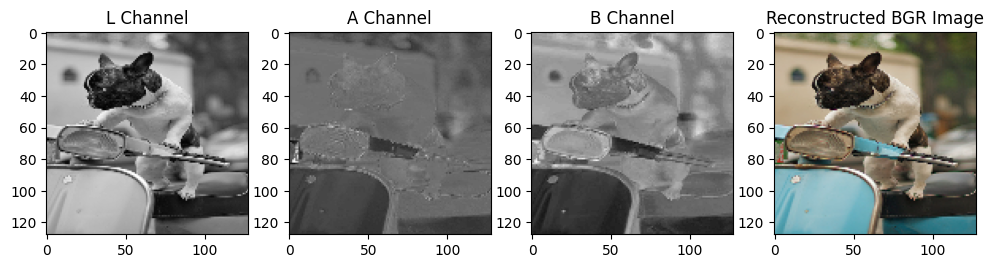

In [17]:
for batch_idx, (L_batch, AB_batch) in enumerate(dataloader):
    
    if batch_idx == 0:
        L_sample = L_batch[0].cpu().numpy().transpose(1, 2, 0).squeeze()
        AB_sample = AB_batch[0].cpu().numpy()
        A_sample = AB_sample[0, :, :]
        B_sample = AB_sample[1, :, :]

        L_sample_vis = (L_sample * 255).astype(np.uint8)
        A_sample_vis = ((A_sample + 1.0) * 128).astype(np.uint8)
        B_sample_vis = ((B_sample + 1.0) * 128).astype(np.uint8)

        LAB_sample_vis = cv2.merge([L_sample_vis, A_sample_vis, B_sample_vis])
        BGR_sample_vis = cv2.cvtColor(LAB_sample_vis, cv2.COLOR_LAB2BGR)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 4, 1)
        plt.title('L Channel')
        plt.imshow(L_sample, cmap='gray')

        plt.subplot(1, 4, 2)
        plt.title('A Channel')
        plt.imshow(A_sample, cmap='gray')

        plt.subplot(1, 4, 3)
        plt.title('B Channel')
        plt.imshow(B_sample, cmap='gray')

        plt.subplot(1, 4, 4)
        plt.title('Reconstructed BGR Image')
        plt.imshow(cv2.cvtColor(BGR_sample_vis, cv2.COLOR_BGR2RGB))

        plt.show()

    if batch_idx >= 2:
        break

<h3> Model Defination </h3>

In [31]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(256, 128)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(128, 64)
        
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))

        dec3 = self.upconv3(enc3)
        dec3 = self.decoder3(torch.cat([dec3, enc2], dim=1))

        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat([dec2, enc1], dim=1)) 

        dec1 = self.upconv1(dec2)
        dec1 = self.conv(dec1)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))

        output = self.final_conv(dec1)
        return output


<h3>Perceptual Loss</h3>

In [32]:
class PerceptualLoss(nn.Module):
    def __init__(self, layer_ids):
        super(PerceptualLoss, self).__init__()
        vgg16 = models.vgg16(pretrained=True).features.eval()  
        self.layer_ids = layer_ids
        self.vgg16 = vgg16
        for param in self.vgg16.parameters():
            param.requires_grad = False 
        self.criterion = nn.MSELoss()

    def forward(self, output, target):
        output_fea = self.get_features(output.float())
        target_fea = self.get_features(target.float())
        
        loss = 0
        for o_f, t_f in zip(output_fea, target_fea):
            loss += self.criterion(o_f, t_f)
        return loss
    
    def get_features(self, x):
        features = []
        for i, layer in enumerate(self.vgg16):
            x = layer(x)
            if i in self.layer_ids:
                features.append(x)
        return features

<h3> Initializing model parameters </h3>

In [33]:
layer_ids = [8, 15, 22, 29]
percep_loss = PerceptualLoss(layer_ids).to(device)
color_net = UNet().to(device)
optimizer = optim.Adam(color_net.parameters(), lr=1e-3)
num_epochs = 40

In [34]:
epoch_m = []
loss_m = []
psnr_m = []

<h3> Model Training </h3>

In [35]:
def psnr(gt_image, pred_images, max_val=1.0):
    mse = torch.mean((gt_image - pred_images) ** 2)
    psnr_val = 10 * torch.log10((max_val ** 2) / mse)
    return psnr_val

In [ ]:
for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    psnr_sum = 0.0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for L,AB in progress_bar:
        L, AB = L.to(device), AB.to(device)
        optimizer.zero_grad()

        output_AB = color_net(L)
        pixel_loss = nn.MSELoss()(output_AB,AB)

        output_LAB = torch.cat([L , output_AB], dim = 1)
        target_LAB = torch.cat([L , AB], dim = 1)

        p_loss = percep_loss(output_LAB, target_LAB)
        loss = pixel_loss + 0.01 * p_loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        psnr_batch = psnr(target_LAB, output_LAB)
        psnr_sum += psnr_batch
        
        del L, AB, output_AB, target_LAB, output_LAB, p_loss, pixel_loss, loss
        gc.collect()
        torch.cuda.empty_cache()
        
    
    avg_epoch_loss = epoch_loss/len(dataloader)
    avg_psnr = psnr_sum / len(dataloader)
  
    epoch_m.append(epoch+1)
    loss_m.append(avg_epoch_loss)
    psnr_m.append(avg_psnr)
  
    print(f"Epoch {epoch+1} , Loss:{avg_epoch_loss}, PSNR : {avg_psnr}")
    
    if (epoch+1)%5==0 and epoch+1>=10:
        torch.save(color_net.state_dict() , f'{epoch+1}_unet_ploss_vgg19.pth')

torch.save(color_net.state_dict() , 'final_unet_ploss_vgg19.pth')

Epoch 1/40:  24%|██▎       | 602/2549 [04:49<15:13,  2.13it/s]

<h3>Loss Curve</h3>

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epoch_m,loss_m,label='Loss',marker='o',linestyle='-')
plt.show()

<h3> Visualizing random images from training dataset. </h3>

In [ ]:
def visualize(image_pth, model):
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128,128), interpolation=cv2.INTER_LINEAR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    L, A, B = cv2.split(image)
    L_norm = L / 255.0
    AB_pred = model(L_norm)
    A_pred, B_pred = cv2.split(AB_pred)
    A_pred = ((A_pred + 1.0) * 128).astype(np.uint8)
    B_pred = ((B_pred + 1.0) * 128).astype(np.uint8)

    image_pred = cv2.cvtColor(torch.cat([L, A_pred, B_pred],dim = 1), cv2.COLOR_LAB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)



    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title('L Channel')
    plt.imshow(L, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title('Predicted')
    plt.imshow(image_pred, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('Ground Truth')
    plt.imshow(image, cmap='gray')

    plt.show()



<h3> Loading model </h3>

In [ ]:
model = Unet()
model_path = '/kaggle/working/unet_ploss_vgg19.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

<h3> Defining functions for visualizing the images </h3>

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel = image_lab[:,:,0]
    l_channel_normalized = l_channel / 255.0
    return l_channel_normalized, image_lab

def scale_ab_channels(ab_channels):
    return (ab_channels * 128) - 128

def combine_channels(l_channel, ab_channels):
    l_channel = np.expand_dims(l_channel, axis=-1) * 255.0 
    lab_image = np.concatenate((l_channel, ab_channels), axis=-1)
    return lab_image

def display_images(original, predicted, ground_truth):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title('Original (L)')
    axs[0].axis('off')
    axs[1].imshow(predicted)
    axs[1].set_title('Predicted')
    axs[1].axis('off')
    axs[2].imshow(ground_truth)
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')
    plt.show()

<h3> Randomly selecting 10 images from dataset and then visualizing them. </h3>

In [ ]:
def sample_image_paths(directory, sample_size=10):
    all_files = os.listdir(directory)
    
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    image_files = [file for file in all_files if os.path.splitext(file)[1].lower() in image_extensions]
    
    sampled_files = random.sample(image_files, sample_size)
    
    sampled_paths = [os.path.join(directory, file) for file in sampled_files]
    
    return sampled_paths


directory_path = '/kaggle/working/test2014'
sampled_image_paths = sample_image_paths(directory_path)


for image_path in sampled_image_paths:
    l_channel, image_lab = preprocess_image(image_path)

    l_channel_input = np.expand_dims(l_channel, axis=0)
    l_channel_input = np.expand_dims(l_channel_input, axis=1)  
    l_channel_tensor = torch.from_numpy(l_channel_input).float().to(device)

    with torch.no_grad():
        predicted_ab_channels = model(l_channel_tensor).squeeze(0).cpu().numpy()

    predicted_ab_channels = predicted_ab_channels.transpose(1, 2, 0)  
    scaled_ab_channels = scale_ab_channels(predicted_ab_channels)

    predicted_image_lab = combine_channels(l_channel, scaled_ab_channels)

    predicted_image_rgb = cv2.cvtColor(predicted_image_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

    ground_truth_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)

    display_images(image_lab[:,:,0], predicted_image_rgb, ground_truth_rgb)


<h3> For visualizing a single image. </h3>

In [ ]:
def visualize(image_path,model):
    l_channel, image_lab = preprocess_image(image_path)

    l_channel_input = np.expand_dims(l_channel, axis=0)
    l_channel_input = np.expand_dims(l_channel_input, axis=1) 
    l_channel_tensor = torch.from_numpy(l_channel_input).float().to(device)

    with torch.no_grad():
        predicted_ab_channels = model(l_channel_tensor).squeeze(0).cpu().numpy()

    predicted_ab_channels = predicted_ab_channels.transpose(1, 2, 0)
    scaled_ab_channels = scale_ab_channels(predicted_ab_channels)

    predicted_image_lab = combine_channels(l_channel, scaled_ab_channels)

    predicted_image_rgb = cv2.cvtColor(predicted_image_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

    ground_truth_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)

    display_images(image_lab[:,:,0], predicted_image_rgb, ground_truth_rgb)

In [ ]:
img_pathi = input("Enter your image path")
visualize(img_pathi,model)